In [1]:
import torch as t
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from periodic_padding import periodic_padding
from hamiltonian_diff import model
from cell_typing import CellKind, CellMap

In [2]:
t.device("cuda")

device(type='cuda')

In [3]:
class STETest(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input == 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [5]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [5]:
def unfold_conv(batch: t.Tensor) -> t.Tensor:
    unfold_transform = t.nn.Unfold(kernel_size=3)
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    return batch_reshaped

In [19]:
def grid2gsc(grid, scale_min, scale_max):
    mask = t.logical_and(grid != 0, grid != 1)
    print(mask)
    p_vec = grid[mask].unsqueeze(1)
    p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
    print(p_vec_expanded)
    gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
    print(gumbel_samples)
    cell_ids = 1 - gumbel_samples[:, 0]
    reconstruction = t.zeros(*grid.shape, device="cpu")
    reconstruction[t.logical_not(mask)] += grid[t.logical_not(mask)]
    reconstruction[mask] += cell_ids
    reconstruction *= scale_max
    reconstruction[reconstruction == 0] += scale_min
    return reconstruction

In [6]:
def reconstruction_loss(ref_pic, rec_pic):
    return t.log(t.sum((ref_pic - rec_pic)**2))

In [21]:
def loss_fn(grid, ref_pic):
    conv_mat = unfold_conv(grid)
    rec_pic = grid2gsc(grid, scale_min=0, scale_max=50)
    return bg_contacts(conv_mat)*10 + reconstruction_loss(ref_pic, rec_pic)

In [22]:
input_state = t.load("./data/0.pt", map_location=t.device('cpu'))

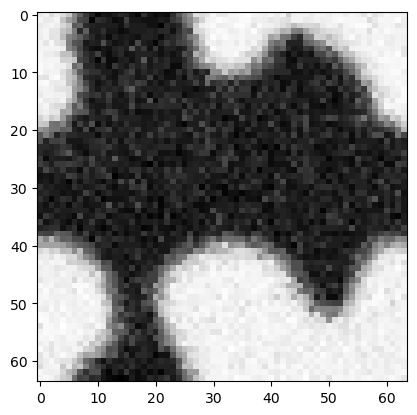

In [23]:
plt.imshow(input_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)

In [24]:
threshold = 25

grid = input_state[0].detach().clone()
grid[grid < 25] = 0
grid[grid >= 25] = 1
grid = grid.unsqueeze(0)

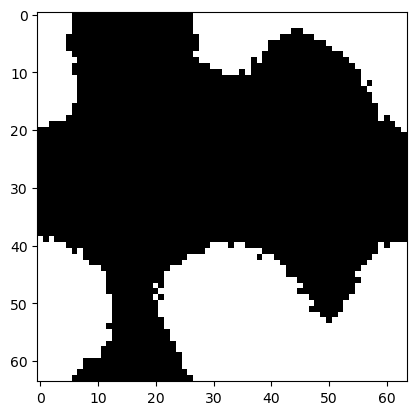

In [25]:
plt.imshow(grid[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [26]:
test_grid = grid.detach().clone()

In [27]:
test_grid.requires_grad_()
loss = loss_fn(test_grid, input_state)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


In [28]:
loss

tensor(6655.6289, grad_fn=<AddBackward0>)

In [29]:
t.autograd.grad(loss, test_grid)

(tensor([[[89.9993, 89.9993, 89.9992,  ..., 89.9992, 89.9993, 89.9993],
          [89.9993, 89.9993, 89.9993,  ..., 89.9993, 89.9993, 89.9992],
          [89.9993, 89.9993, 89.9994,  ..., 89.9992, 89.9992, 89.9993],
          ...,
          [89.9991, 89.9993, 89.9993,  ..., 89.9992, 89.9993, 89.9992],
          [89.9993, 89.9993, 89.9993,  ..., 89.9993, 89.9993, 89.9993],
          [89.9993, 89.9994, 89.9994,  ..., 89.9993, 89.9993, 89.9993]]]),)

In [30]:
for i in range(1000):
    loss = loss_fn(test_grid, input_state)
    grads = t.autograd.grad(loss, test_grid)[0]
    test_grid = t.clamp(test_grid - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


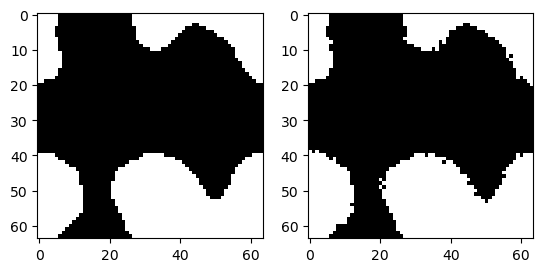

In [31]:
opt_grid = grid2gsc(test_grid, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[0].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].imshow(grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

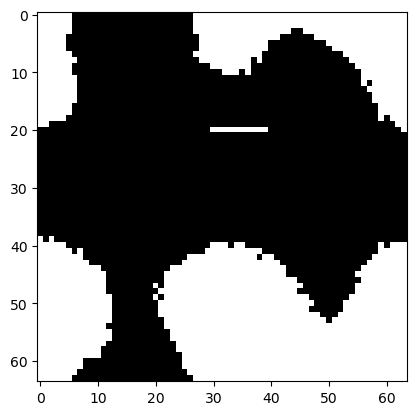

In [32]:
test2 = grid.detach().clone()
test2[0,20,30:40] = 0
plt.imshow(test2[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [33]:
train_test2 = test2.detach().clone()
train_test2.requires_grad_()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)

In [34]:
for i in range(1000):
    loss = loss_fn(train_test2, input_state)
    grads = t.autograd.grad(loss, train_test2)[0]
    train_test2 = t.clamp(train_test2 - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


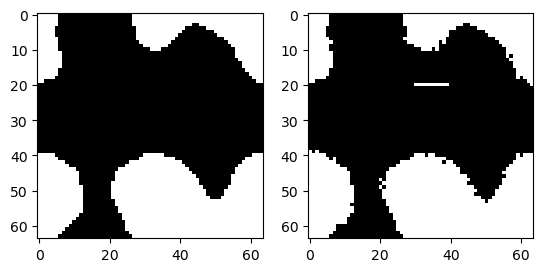

In [35]:
opt_grid = grid2gsc(train_test2, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[0].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].imshow(test2[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [36]:
test3 = test2.detach().clone()
test3[0,20:25,10:20] = 0

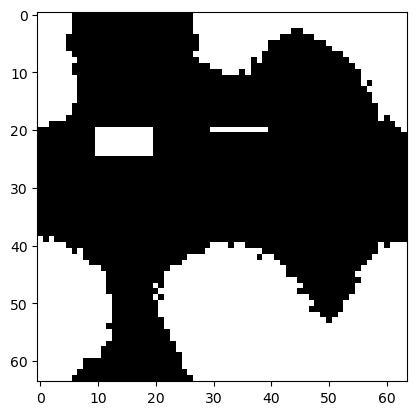

In [37]:
plt.imshow(test3[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [38]:
train_test3 = test3.detach().clone()
train_test3.requires_grad_()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)

In [39]:
for i in range(1000):
    loss = loss_fn(train_test3, input_state)
    grads = t.autograd.grad(loss, train_test3)[0]
    train_test3 = t.clamp(train_test3 - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'initial')

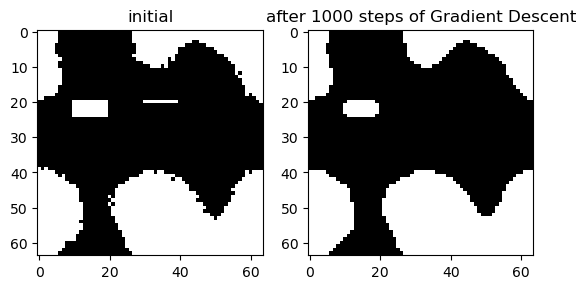

In [40]:
opt_grid = grid2gsc(train_test3, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[1].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("after 1000 steps of Gradient Descent")
axs[0].imshow(test3[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)
axs[0].set_title("initial")

In [41]:
input_state_ref = input_state[0].detach().clone().unsqueeze(0)
input_state_ref[0,20,30:40] = 0
input_state_ref[0,20:25,10:20] = 0

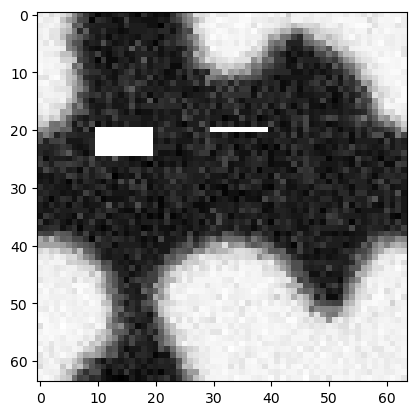

In [42]:
plt.imshow(input_state_ref[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)

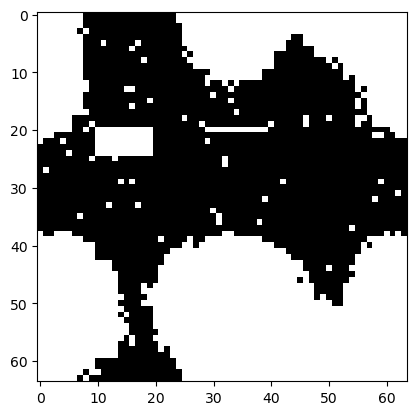

In [43]:
threshold = 40

grid = input_state[0].detach().clone()
grid[grid < threshold] = 0
grid[grid >= threshold] = 1
grid = grid.unsqueeze(0)
grid[0,20,30:40] = 0
grid[0,20:25,10:20] = 0
plt.imshow(grid[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [44]:
ex_3_grid = grid.detach().clone()
ex_3_grid.requires_grad_()
for i in range(1000):
    loss = loss_fn(ex_3_grid, input_state)
    grads = t.autograd.grad(loss, ex_3_grid)[0]
    ex_3_grid = t.clamp(ex_3_grid - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        [0.9300, 0.0700],
        [0.9500, 0.0500],
        [0.9900, 0.0100],
        

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([], size=(0, 2), grad_fn=<CatBackward0>)
tensor([], size=(0, 2), grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'initial')

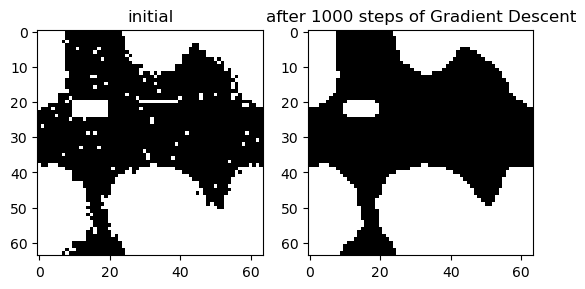

In [45]:
opt_grid = grid2gsc(ex_3_grid, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[1].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("after 1000 steps of Gradient Descent")
axs[0].imshow(grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)
axs[0].set_title("initial")

In [4]:
from os import path, listdir, getcwd
nuclei_path = path.join(getcwd(), "data", "nuclei")
listdir(nuclei_path)

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
 '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
 '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13',
 '0532c64c2fd0c4d3188cc751cdfd566b

In [5]:
import matplotlib.image as mpimg
input_path = path.join(nuclei_path, listdir(nuclei_path)[0])
print(listdir(path.join(input_path, "images"))[-1])
image_path = path.join(input_path, "images", listdir(path.join(input_path, "images"))[-1])
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)

00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png
(256, 256, 4)


NameError: name 'plt' is not defined

In [6]:
from skimage.color import rgba2rgb
img_rgb = rgba2rgb(img)
print(img_rgb.shape)
plt.imshow(img_rgb)

(256, 256, 3)


NameError: name 'plt' is not defined

In [2]:
from skimage.color import rgb2gray
img_gsc = rgb2gray(img_rgb)
print(img_gsc.shape)
plt.imshow(img_gsc, cmap=plt.cm.gray)

NameError: name 'img_rgb' is not defined

In [1]:
snippet = img_gsc[200:250, 100:150]
print(snippet.shape)
plt.imshow(snippet, cmap=plt.cm.gray, vmin=0, vmax=1)

NameError: name 'img_gsc' is not defined

In [55]:
grid = t.zeros_like(t.tensor(snippet))
grid = grid.unsqueeze(0)
ref = t.from_numpy(snippet)
ref = ref.unsqueeze(0)
max_intensity = t.max(ref)
min_intensity = t.min(ref)
mean_intensity = t.mean(ref)
std_intensity = t.std(ref)

In [56]:
print(max_intensity)
print(min_intensity)
print(mean_intensity)
print(std_intensity)

tensor(0.3725)
tensor(0.0118)
tensor(0.0884)
tensor(0.0804)


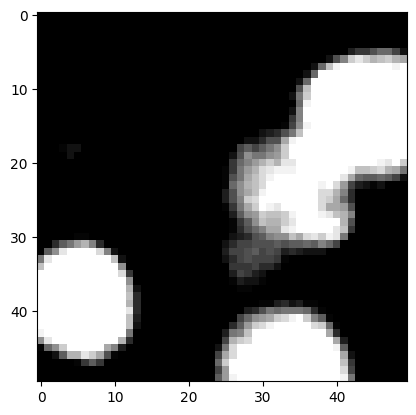

In [57]:
from torchvision import transforms
centering = transforms.Normalize(mean_intensity, std_intensity)
ref_centered = centering(ref)
plt.imshow(ref_centered[0], cmap=plt.cm.gray, vmin=0, vmax=1)

In [46]:
print(t.max(ref_centered))

tensor(3.5356)


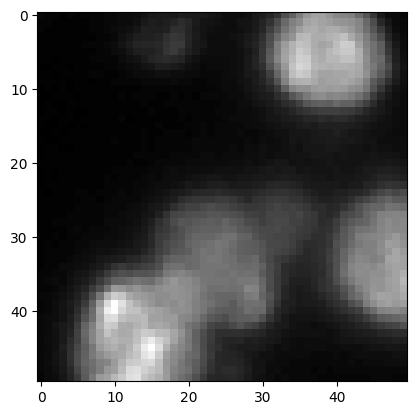

In [144]:
center2  = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered))) 
plt.imshow(center2[0].T, cmap=plt.cm.gray, vmin=0, vmax=1)

In [59]:
center2

tensor([[[0.0326, 0.0217, 0.0217,  ..., 0.0326, 0.0326, 0.0217],
         [0.0217, 0.0217, 0.0109,  ..., 0.0543, 0.0435, 0.0435],
         [0.0217, 0.0109, 0.0109,  ..., 0.0761, 0.0652, 0.0543],
         ...,
         [0.0543, 0.0870, 0.1196,  ..., 0.0543, 0.0326, 0.0326],
         [0.0435, 0.0435, 0.0543,  ..., 0.0543, 0.0326, 0.0217],
         [0.0217, 0.0326, 0.0326,  ..., 0.0543, 0.0326, 0.0217]]])

In [167]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [181]:
def grid2gsc(grid, scale_min, scale_max, scale_std):
    min_sampler = t.distributions.Normal(scale_min, scale_std)
    max_sampler = t.distributions.Normal(scale_max, scale_std)
    mask = t.logical_and(grid != 0, grid != 1)
    #print(mask)
    p_vec = grid[mask].unsqueeze(1)
    p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
    #print(p_vec_expanded)
    gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
    #print(gumbel_samples)
    cell_ids = 1 - gumbel_samples[:, 0]
    reconstruction = t.zeros(*grid.shape, device="cpu")
    reconstruction[t.logical_not(mask)] += grid[t.logical_not(mask)]
    reconstruction[mask] += cell_ids
    reconstruction *= max_sampler.sample(reconstruction.shape)
    reconstruction[reconstruction == 0] += min_sampler.sample(reconstruction[reconstruction == 0].shape)
    return reconstruction

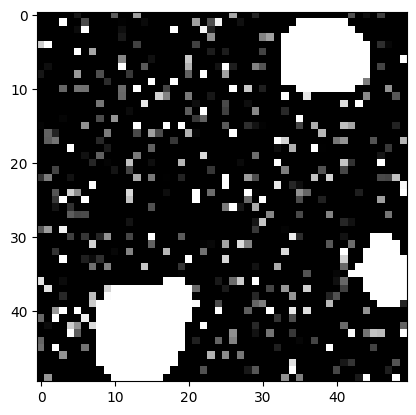

In [182]:
test_rec = grid2gsc(center2, t.min(ref_centered), t.max(ref_centered), t.std(ref_centered))
plt.imshow(test_rec.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

In [183]:
def reconstruction_loss(ref_pic, rec_pic):
    return t.log(t.sum((ref_pic - rec_pic)**2))

In [190]:
def loss_fn(grid, ref_pic):
    conv_mat = unfold_conv(grid)
    rec_pic = grid2gsc(grid, t.min(ref_pic), t.max(ref_pic), t.std(ref_pic))
    return bg_contacts(conv_mat)*100000 + reconstruction_loss(ref_pic, rec_pic)

In [191]:
center2.requires_grad_()
for i in range(1000):
    loss = loss_fn(center2, ref_centered)
    grads = t.autograd.grad(loss, center2)[0]
    center2 = t.clamp(center2 - 0.001 * grads, min=0, max=1)

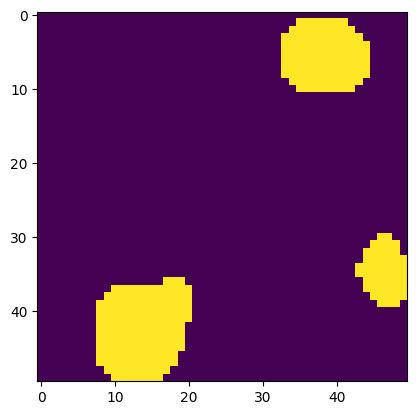

In [195]:
test_rec = grid2gsc(center2, t.min(ref_centered), t.max(ref_centered), t.std(ref_centered))
plt.imshow(test_rec.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
plt.imshow(center2.squeeze().T.detach().cpu().numpy())

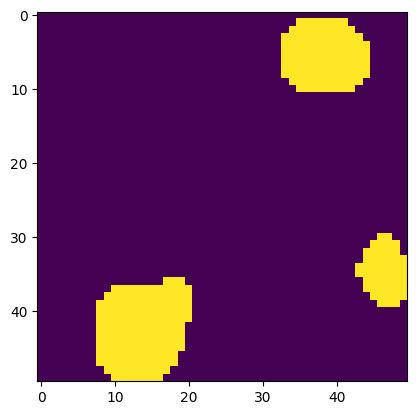

In [196]:
mask = t.logical_and(center2 != 0, center2 != 1)
#print(mask)
p_vec = center2[mask].unsqueeze(1)
p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
#print(p_vec_expanded)
gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
#print(gumbel_samples)
cell_ids = 1 - gumbel_samples[:, 0]
reconstruction = t.zeros(*center2.shape, device="cpu")
reconstruction[t.logical_not(mask)] += center2[t.logical_not(mask)]
reconstruction[mask] += cell_ids
plt.imshow(reconstruction.T.detach().squeeze().numpy())

In [203]:
xs = t.randint(0, reconstruction.shape[-1], size=(2,))
ys = t.randint(0, reconstruction.shape[-2], size=(2,))
print(reconstruction.shape[-1],reconstruction.shape[-2])
print(xs, ys)
def euclid_dist(c1, c2):
    return t.sqrt(t.sum((c1-c2)**2))

def get_label(c1, centroids):
    best_label = None
    best_dist = float("inf")
    for idx, centroid in enumerate(centroids):
        dist = euclid_dist(c1, centroid)
        #print(dist)
        if dist <= best_dist:
            best_label = idx+1
            best_dist = dist
    return best_label

def calc_centroid(points):
    #print(points.shape)
    return t.concat([t.floor(t.mean(points[:,1].type(t.float))).unsqueeze(0), t.floor(t.mean(points[:,2].type(t.float))).unsqueeze(0)])

50 50
tensor([21, 18]) tensor([12,  8])


In [199]:
from matplotlib import colors
def knn(num_iter, num_classes, grid, visualize=False):
    xs = t.randint(0, grid.shape[-1], size=(num_classes,))
    ys = t.randint(0, grid.shape[-2], size=(num_classes,))
    centroids = t.hstack((xs.unsqueeze(1), ys.unsqueeze(1)))
    print(centroids.shape)
    
    for step in range(num_iter):
        points = (grid > 0).nonzero()
        for idx in range(points.shape[0]):
            cur = points[idx,1:]
            label = get_label(cur, centroids)
            grid[0, cur[0], cur[1]] = label
        for centroid_idx in range(centroids.shape[0]):
            members = (grid == (centroid_idx+1)).nonzero()
            centroids[centroid_idx] = calc_centroid(members)
        if visualize:
            fig, axs = plt.subplots()
            scheme = ["black", 'b','y','g','r']
            cmap = colors.ListedColormap(scheme)
            axs.imshow(grid.T.detach().squeeze().numpy(), cmap=cmap)
            plt.gca().invert_yaxis()
            for j in range (centroids.shape[0]):
                axs.scatter(centroids[j,0], centroids[j,1], color=[scheme[j+1]])
    return grid, centroids
            
labeled_rec = reconstruction.detach().clone()
labeled_rec, centroids = knn(100, 4, labeled_rec)

torch.Size([4, 2])


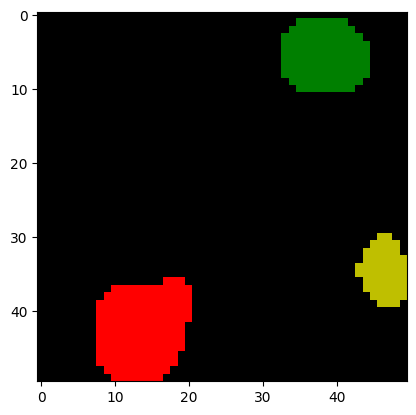

In [202]:
fig, axs = plt.subplots()
scheme = ["black", 'b','y','g','r']
cmap = colors.ListedColormap(scheme)
axs.imshow(labeled_rec.T.detach().squeeze().numpy(), cmap=cmap)
#plt.gca().invert_yaxis()
#for j in range (centroids.shape[0]):
#    axs.scatter(centroids[j,0], centroids[j,1], color=[scheme[j+1]])

# Next step

In [61]:
def unfold_conv(batch: t.Tensor) -> t.Tensor:
    unfold_transform = t.nn.Unfold(kernel_size=3)
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    return batch_reshaped

In [151]:
def bg_contacts(id, conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum(0**((id - conv_mat)**2) * 0**((id - conv_mat[:,:,4])**2).T.expand(num_convs, 9))

In [152]:
def volume(cell_id: t.Tensor, batch: t.Tensor):
    return t.sum()

In [160]:
def energy(IDs, lambda_vol, target_vol, lambda_perim, grid):
    tot_energy = 0
    for id in IDs:
        tot_energy += lambda_vol * (volume(id, grid) - target_vol)**2
    return tot_energy

In [161]:
labeled_rec.requires_grad_()
IDs = [1,2,3,4]
cur_e = energy(IDs, 1, 20, 1, labeled_rec)
grads = t.autograd.grad(cur_e, labeled_rec)[0]

In [48]:
from tqdm import tqdm
grid.requires_grad_()
for i in tqdm(range(1000)):
    loss = loss_fn(grid, ref, max_intensity)
    grads = t.autograd.grad(loss, grid)[0]
    #print(grads)
    grid = t.clamp(grid - 0.01 * grads, min=0, max=1)

100%|██████████| 1000/1000 [00:07<00:00, 132.83it/s]
